In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import torchvision
from torchvision import transforms

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob 
from PIL import Image

In [4]:
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy

In [5]:
torch.__version__

'1.13.1+cu117'

In [6]:
#获取测试数据路径
# train_irimgs_path = glob.glob('data/MSRS-main/train/ir/*.png')
# train_viimgs_path = glob.glob('data/MSRS-main/train/vi/*.png')
train_irimgs_path = glob.glob('data/TNO/ir/*.png')
train_viimgs_path = glob.glob('data/TNO/vi/*.png')
# train_irimgs_path = glob.glob('data/output/output_ir/*.png')
# train_viimgs_path = glob.glob('data/output/output_vi/*.png')
# 获取测试数据路径
test_irimgs_path = glob.glob('data/MSRS-main/test/ir/*.png')
test_viimgs_path = glob.glob('data/MSRS-main/test/vi/*.png')

In [7]:
transform = transforms.Compose([
                             transforms.Resize(256),
                             transforms.CenterCrop(256),
                             transforms.ToTensor(),
                             transforms.Normalize(
                                 # mean=[0.485, 0.456, 0.406], 
                                 # std=[0.229, 0.224, 0.225]
                                mean=0.5, 
                                std=0.5
                             )
                            ])

In [8]:
vi_img = Image.open(train_viimgs_path[1])
ir_img = Image.open(train_irimgs_path[1])
ir_img = ir_img.convert('RGB')

In [9]:
np.array(ir_img).shape,np.array(vi_img).shape

((576, 768, 3), (576, 768, 3))

In [10]:
class FusionDataset(data.Dataset):
    def __init__(self,ir_path,vi_path):
        self.ir_path = train_irimgs_path
        self.vi_path = train_viimgs_path
    def __getitem__(self,idx):
        # 得到路径
        vi_path = self.vi_path[idx]
        ir_path = self.ir_path[idx]
        # 根据路径得到图片
        vi_img = Image.open(vi_path)
        ir_img = Image.open(ir_path) #ir红外读取为灰度秃了
        vi_img = transform(vi_img)
        ir_img = ir_img.convert('RGB')# 将灰度图转换为三通道再变化
        ir_img = transform(ir_img)
        return vi_img,ir_img
    def __len__(self):
        return len(self.ir_path)
        

In [11]:

train_ds = FusionDataset(train_irimgs_path,train_viimgs_path)
test_ds = FusionDataset(test_irimgs_path,test_viimgs_path)

In [12]:
BATCHSIZE = 128
train_dl = data.DataLoader(dataset=train_ds,
                          batch_size=BATCHSIZE,
                          shuffle=True)

test_dl = data.DataLoader(dataset=test_ds,
                          batch_size=BATCHSIZE,
                          shuffle=False)

In [13]:
vi_batch,ir_batch = next(iter(train_dl))

In [14]:
ir_batch.shape,vi_batch.shape

(torch.Size([42, 3, 256, 256]), torch.Size([42, 3, 256, 256]))

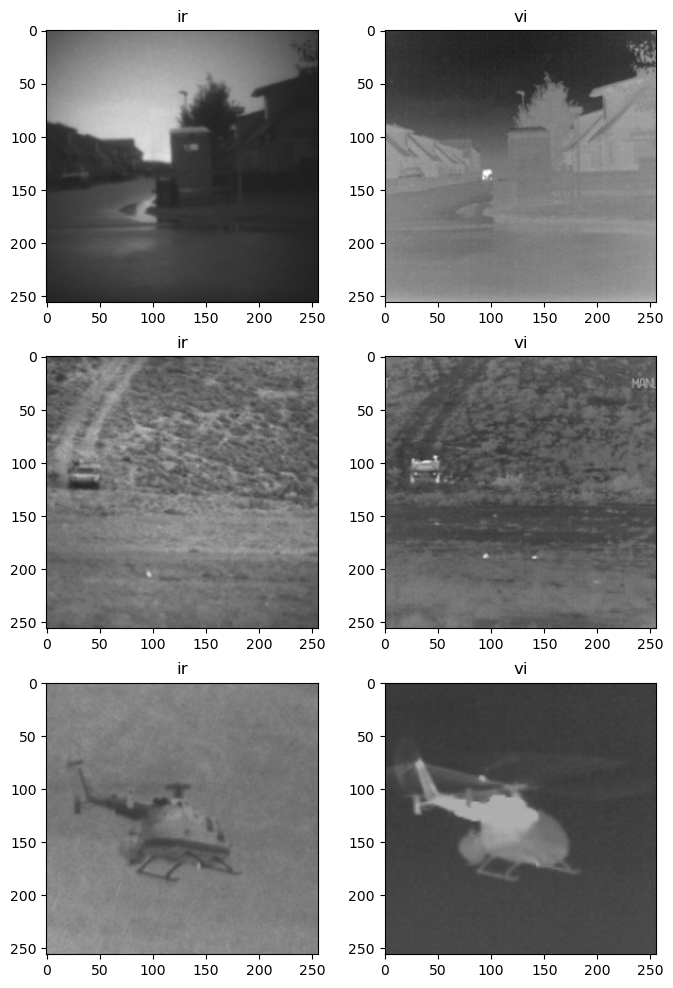

In [15]:
plt.figure(figsize = (8,12))
for i,(vi,ir) in enumerate(zip(ir_batch[:3],vi_batch[:3])):
    ir = (ir.permute(1,2,0).numpy()+1)/2
    vi = (vi.permute(1,2,0).numpy()+1)/2
    # ir = (ir.permute(1,2,0).numpy())
    # vi = (vi.permute(1,2,0).numpy())
    plt.subplot(3,2,2*i+1)
    plt.title('ir')
    plt.imshow(ir)
    plt.subplot(3,2,2*i+2)
    plt.title('vi')
    plt.imshow(vi)

In [186]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Define the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(6, 64, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, 3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Define the decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Tanh()
        )
    def forward(self, x):
        # print(f'初始图像：{x.shape}')
        x = self.encoder(x)
        # print(f'编码器图像：{x.shape}')
        x = self.decoder(x)
        # print(f'解码器图像：{x.shape}')
        return x

In [187]:
#定义下采样模块
class Downsample(nn.Module):
    def __init__(self,in_channels,out_channels):
        super(Downsample,self).__init__()
        self.conv_relu = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,
                     kernel_size=3,
                     stride = 2,
                     padding=1),
            nn.LeakyReLU(inplace=True)
        )
        self.bn = nn.BatchNorm2d(out_channels)
    def forward(self,x,is_bn=True):
    # 生成器的输出层和判别器的输入层不使用BN
        x = self.conv_relu(x)
        if is_bn:
            x = self.bn(x)
        return x


In [188]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.main = Autoencoder()
    def forward(self,x1,x2):
        x = torch.cat([x1,x2],axis = 1)
        # x = x1*0.5 + x2*0.5
        x = self.main(x)
        return x

In [189]:
class Discriminator(nn.Module):
    # ir + vi concat
    def __init__(self):
        super(Discriminator,self).__init__()
        self.down1 = Downsample(3,64)
        self.down2 = Downsample(64,128)
        self.conv1 = nn.Conv2d(128,256,3)
        self.bn = nn.BatchNorm2d(256)
        self.last = nn.Conv2d(256,1,3)
    def forward(self,ir,vi):
        # x = torch.cat([ir,vi],axis = 1)
        # x = ir*0.5 + vi*0.5
        x = vi
        x = self.down1(x,is_bn=False)
        x = self.down2(x,is_bn=False)
        x = F.dropout2d(self.bn(F.leaky_relu(self.conv1(x))))
        x = torch .sigmoid(self.last(x))
        return x

In [190]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [191]:
gen = Generator().to(device)
dis = Discriminator().to(device)
# if torch.cuda.device_count() > 1:
#     gen = nn.DataParallel(gen)  # 就在这里wrap一下，模型就会使用所有的GPU
#     dis = nn.DataParallel(dis)  # 就在这里wrap一下，模型就会使用所有的GPU

In [ ]:
d_optimizer = torch.optim.Adam(dis.parameters(),lr = 1e-4,betas=(0.5,0.999))
g_optimizer = torch.optim.Adam(gen.parameters(),lr = 1e-4,betas=(0.5,0.999))

In [ ]:
# 定义损失函数
# loss_fn = torch.nn.BCELoss()
loss_fn = torch.nn.MSELoss()

# L1

In [ ]:
LAMDA = 9

In [ ]:
def calculate_metrics(vi, ir,fusion):
    # Information Entropy (EN)
    def calculate_entropy(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        entropy_value = shannon_entropy(img_gray)
        return entropy_value

    # Standard Deviation (SD)
    def calculate_sd(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        sd_value = np.std(img_gray)
        return sd_value

    # Structural Similarity Index (SSIM)
    def calculate_ssim(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        ssim_index_A, _ = ssim(img1_gray, fusion_gray, full=True)
        ssim_index_B, _ = ssim(img2_gray, fusion_gray, full=True)
        return (ssim_index_A + ssim_index_B)/2 

    

    # Correlation Coefficient (CC)
    def calculate_cc(vi, ir ,fusion):
        img1_flat = vi.flatten()
        img2_flat = ir.flatten()
        fusion_flat = fusion.flatten()
        
        correlation_coefficient_A = np.corrcoef(img1_flat, fusion_flat)[0, 1]
        correlation_coefficient_B = np.corrcoef(img2_flat, fusion_flat)[0, 1]
        
        return (correlation_coefficient_A + correlation_coefficient_B)/2

    # Spatial Frequency (SF)
    def calculate_sf(fusion):
        img_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        f = np.fft.fft2(img_gray)
        fshift = np.fft.fftshift(f)
        magnitude_spectrum = 20 * np.log(np.abs(fshift))
        spatial_frequency = np.sum(magnitude_spectrum) / img_gray.size
        return spatial_frequency

    # Variable Luminance Fusion Index (VLF)
    def calculate_vlf(vi, ir ,fusion):
        img1_gray = cv2.cvtColor(vi, cv2.COLOR_BGR2GRAY)
        img2_gray = cv2.cvtColor(ir, cv2.COLOR_BGR2GRAY)
        fusion_gray = cv2.cvtColor(fusion, cv2.COLOR_BGR2GRAY)
        
        vlf_value_A = np.sum(np.abs(img1_gray - fusion_gray)) / img1_gray.size
        vlf_value_B = np.sum(np.abs(img2_gray - fusion_gray)) / img2_gray.size
        
        return (vlf_value_A + vlf_value_B)/2

    # Calculate metrics
    entropy_value = calculate_entropy(fusion)
    sd_value = calculate_sd(fusion)
    ssim_value = calculate_ssim(vi, ir,fusion)
    cc_value = calculate_cc(vi, ir,fusion)
    sf_value = calculate_sf(fusion)
    vlf_value = calculate_vlf(vi, ir,fusion)
    return {
        'Entropy': entropy_value,
        'Standard Deviation': sd_value,
        'SSIM': ssim_value,
        'Correlation Coefficient': cc_value,
        'Spatial Frequency': sf_value,
        'Variable Luminance Fusion Index': vlf_value
    }

In [ ]:
def genarate_images(model,ir,vi):
    prediction = model(vi,ir).permute(0,2,3,1).detach().cpu().numpy()
    ir = ir.permute(0,2,3,1).cpu().numpy()
    vi = vi.permute(0,2,3,1).cpu().numpy()
    plt.figure(figsize=(10,10))
    display_list = [ir[0],vi[0],prediction[0]]
    fusion_result = calculate_metrics(vi[0], ir[0],prediction[0])
    print(fusion_result)
    title = ['ir','vi','fusion']
    for i in range(3):
        plt.subplot(1,3,i+1)
        plt.title(title[i])
        plt.imshow(display_list[i]*0.5+0.5)
        plt.axis('off')
    plt.show()
    return fusion_result

In [ ]:
D_loss = []
G_loss = []
res = []
for epoch in range(5000):
    D_epoch_loss = 0
    G_epoch_loss = 0
    count = len(train_dl)
    for step,(vi,ir) in enumerate(train_dl):
        ir = ir.to(device)
        vi = vi.to(device)
        d_optimizer.zero_grad()
        #输入真实图片，判别器判定为真
        disc_real_output = dis(ir,vi) #输入真实的成对图片
        d_real_loss = loss_fn(disc_real_output,torch.ones_like(disc_real_output,device = device))
        d_real_loss.backward()
        #生成图片
        gen_output = gen(vi,ir)
        vi_disc_gen_output = dis(ir,gen_output.detach())#输入生成图像，判断可见光
        vi_d_fake_loss = loss_fn(vi_disc_gen_output,torch.zeros_like(vi_disc_gen_output,device = device))
        vi_d_fake_loss.backward()
        # 判定器的loss由两部分组成
        disc_loss = d_real_loss +(vi_d_fake_loss)
        #更新判别器参数
        d_optimizer.step()
        g_optimizer.zero_grad()
        # 将生成的图片放入判别器
        vi_disc_gen_out = dis(ir,gen_output)
        # 得到生成器的损失
        vi_gen_loss_crossentropyloss = loss_fn(vi_disc_gen_out,torch.ones_like(vi_disc_gen_out,device = device))
        vi_gen_l1_loss = torch.mean(torch.abs(gen_output - vi*0.5 - ir*0.5))
        gen_loss = vi_gen_loss_crossentropyloss+ LAMDA*(vi_gen_l1_loss)
        gen_loss.backward()
        #更新生成器梯度
        g_optimizer.step()
        with torch.no_grad():
            D_epoch_loss += disc_loss.item()
            G_epoch_loss += gen_loss.item()
    with torch.no_grad():
        D_epoch_loss /=count
        G_epoch_loss /=count
        D_loss.append(D_epoch_loss)
        G_loss.append(G_epoch_loss)
        # 训练完一个epoch就打印输出
        print("Epoch:",epoch,end=' ')
        if epoch%47==0:
            ress = genarate_images(gen,ir,vi)
            res.append(ress)
        print(f'D_epoch_loss:{D_epoch_loss},G_epoch_loss{G_epoch_loss}')

In [ ]:
plt.plot(range(1, len(D_loss)+1), D_loss, label='D_loss')
plt.plot(range(1, len(G_loss)+1), G_loss, label='G_loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [ ]:
len(D_loss)

In [ ]:
import pandas as pd

In [ ]:
data = pd.DataFrame()
data['res'] = res
data['Gloss'] = G_loss[len(res)]
data['Dloss'] = D_loss[len(res)]

In [ ]:
data.to_excel('excel/01.xlsx')

In [ ]:
# 模型参数保存
torch.save(gen.state_dict(), 'w/model_01.pth')

In [ ]:
# gen = torch.load('w/model_01.pth')
gen.load_state_dict(torch.load('w/model_01.pth'))
for step,(vi,ir) in enumerate(train_dl):
    ir = ir.to(device)
    vi = vi.to(device)
    gen_output = gen(vi,ir)
    print(gen_output.shape)
for item,img in enumerate(gen_output):
    print(img.shape)
    img = img.permute(1,2,0).cpu().detach().numpy()
    plt.figure(figsize=(10,10))
    title = 'fusion'
    plt.imshow(img*0.5+0.5)
    plt.axis('off')  # 关闭坐标轴
    filename = 'result/01/'+str(item)+'.jpg'
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)

In [154]:
import torch
import torch.nn as nn
import torch.fft as fft

class FourierTransformLayer(nn.Module):
    def __init__(self, input_shape):
        super(FourierTransformLayer, self).__init__()
        self.input_shape = input_shape
        self.fft2 = fft.fft2
        self.ifft2 = fft.ifft2

    def forward(self, x):
        # Assuming x is a batch of images with shape (batch_size, channels, height, width)
        batch_size, channels, height, width = x.size()
        # Reshape input to (batch_size * channels, height, width)
        x_reshaped = x.view(batch_size * channels, height, width)
        # Apply 2D Fourier Transform
        fft_result = self.fft2(x_reshaped)
        # Reshape back to original shape
        fft_result = fft_result.view(batch_size, channels, height, width)
        return fft_result.real

In [155]:
# Example usage
input_shape = (3, 256, 256)  # Assuming a color image with shape (3, 256, 256)
net = FourierTransformLayer(input_shape)

In [156]:
torch.unsqueeze(ir_batch[3], 0).shape,torch.unsqueeze(vi_batch[3],0).shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

In [157]:
# Generate a random input batch
input_batch = torch.unsqueeze(ir_batch[3], 0)  # Batch size of 4
# Forward pass through the Fourier Transform Layer
output_batch = net(input_batch)
# Print the shapes of input and output
print("Input Shape:", input_batch.shape)
print("Output Shape after Fourier Transform:", output_batch.shape)

Input Shape: torch.Size([1, 3, 256, 256])
Output Shape after Fourier Transform: torch.Size([1, 3, 256, 256])


In [158]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# 生成一个示例输入张量
# input_tensor = torch.randn(1, 3, 256, 256)

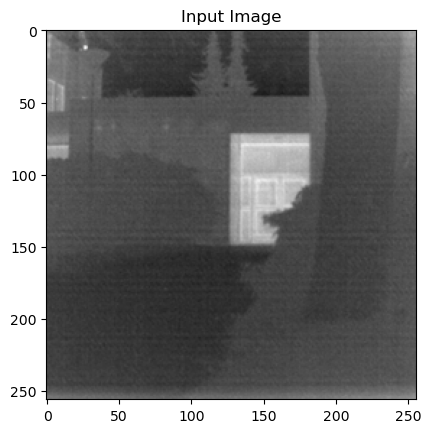

In [159]:
# 从张量中提取numpy数组
image_np = np.transpose(input_batch.squeeze().numpy(), (1, 2, 0))
# 显示图像
plt.imshow(image_np*0.5+0.5)
plt.title("Input Image")
plt.show()

In [160]:
type(output_batch)

torch.Tensor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


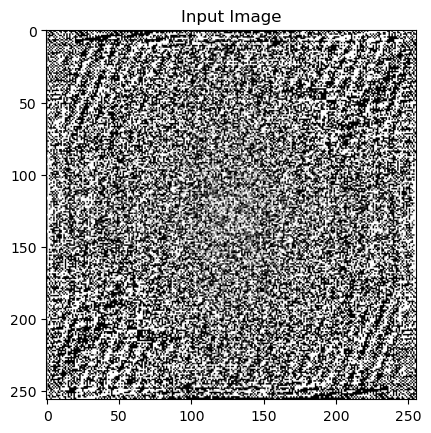

In [161]:
# 从张量中提取numpy数组
image_np = np.transpose(output_batch.squeeze().numpy(), (1, 2, 0))
# 显示图像
plt.imshow(image_np*0.5+0.5)
plt.title("Input Image")
plt.show()

In [162]:
#########################################################################################3

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input's shape:torch.Size([1, 3, 256, 256]) output's shapetorch.Size([1, 3, 256, 256])


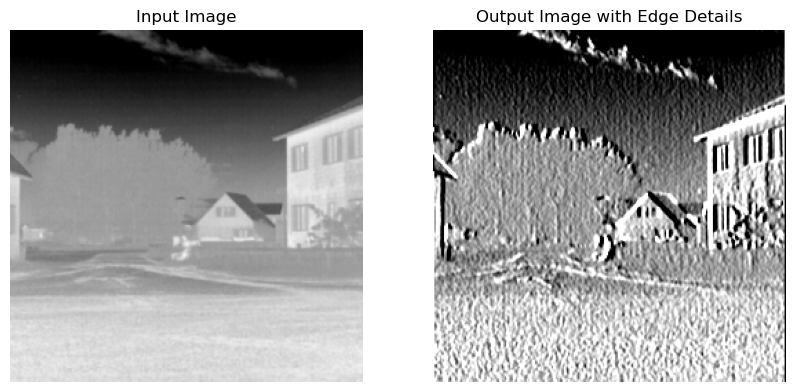

In [163]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 自定义神经网络层来提取图像的边缘细节并保持形状相同
class EdgeDetectionLayer(nn.Module):
    def __init__(self):
        super(EdgeDetectionLayer, self).__init__()
        self.conv1 = nn.Conv2d(3, 3, kernel_size=3, padding=1)
    def forward(self, x):
        edge_map = F.conv2d(x, weight=torch.Tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]*3]).to(x.device), padding=1)
        return x + edge_map
# 创建一个示例图像
image = torch.unsqueeze(ir_batch[6], 0)  # 假设输入图像大小为256x256，3通道

# 初始化自定义边缘检测层
edge_detection_layer = EdgeDetectionLayer()

# 将图像输入神经网络层得到边缘细节张量并保持形状相同
output_image = edge_detection_layer(image)
print(f"input's shape:{image.shape} output's shape{output_image.shape}")
# 绘制输入图像和输出边缘细节结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).detach().numpy()*0.5+0.5)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(output_image.squeeze().permute(1, 2, 0).detach().numpy()*0.5+0.5)
plt.title('Output Image with Edge Details')
plt.axis('off')

plt.show()


torch.Size([1, 1, 256, 256])


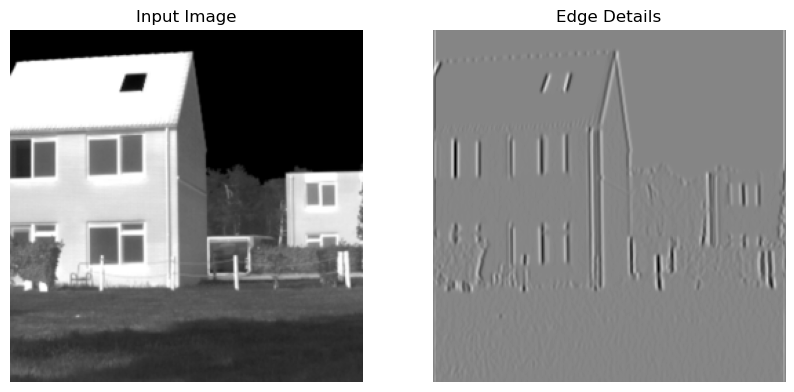

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 自定义神经网络层来提取图像的边缘细节
class EdgeDetectionLayer(nn.Module):
    def __init__(self):
        super(EdgeDetectionLayer, self).__init__()
        self.conv1 = nn.Conv2d(3, 1, kernel_size=3, padding=1)
        
    def forward(self, x):
        x = F.conv2d(x, weight=torch.Tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]*3]).to(x.device),padding=1)
        return x

# 创建一个示例图像
image = torch.unsqueeze(ir_batch[6], 0) # 假设输入图像大小为256x256，3通道

# 初始化自定义边缘检测层
edge_detection_layer = EdgeDetectionLayer()

# 将图像输入神经网络层得到边缘细节张量
edge_map = edge_detection_layer(image)
# 两次
print(edge_map.shape)
edge_map = edge_detection_layer(torch.cat([edge_map,edge_map,edge_map],axis=1))

# 绘制输入图像和输出边缘细节结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).detach().numpy()*0.5+0.5)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(edge_map.squeeze().detach().numpy(), cmap='gray')
plt.title('Edge Details')
plt.axis('off')

plt.show()


In [171]:
torch.Tensor([[[[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]]*3])

tensor([[[[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]],

         [[-1.,  0.,  1.],
          [-2.,  0.,  2.],
          [-1.,  0.,  1.]]]])

In [165]:
####################################################

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 3, 256, 256])


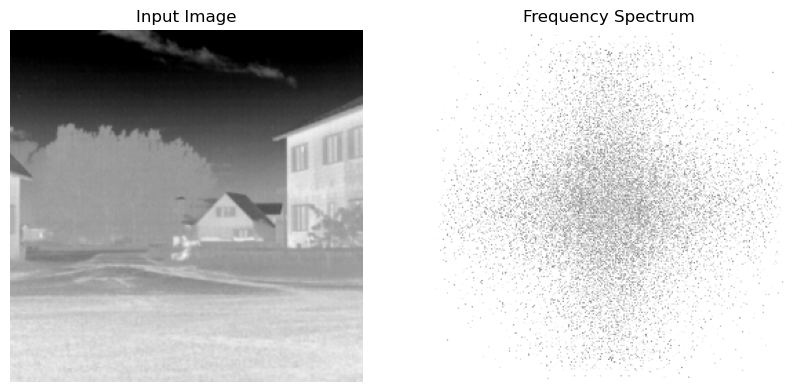

In [167]:
import torch
import torch.nn as nn
import torch.fft
import matplotlib.pyplot as plt

# 自定义神经网络层来提取图像的频谱信息
class FourierTransformLayer(nn.Module):
    def __init__(self):
        super(FourierTransformLayer, self).__init__()
        
    def forward(self, x):
        # 进行傅里叶变换
        x_fft = torch.fft.fftn(x, dim=(-2, -1))
        return x_fft

# 创建一个示例图像
image = torch.unsqueeze(ir_batch[6], 0)  # 假设输入图像大小为256x256，3通道

# 初始化自定义傅里叶变换层
fourier_transform_layer = FourierTransformLayer()

# 将图像输入神经网络层得到频谱张量
spectrum = fourier_transform_layer(image)
print(spectrum.shape)
# 绘制输入图像和输出频谱结果
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.squeeze().permute(1, 2, 0).detach().numpy()*0.5+0.5)
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(torch.log(torch.abs(spectrum) + 1).squeeze().permute(1, 2, 0).detach().numpy()*0.5+0.5, cmap='gray')
plt.title('Frequency Spectrum')
plt.axis('off')

plt.show()
